<a href="https://colab.research.google.com/github/leenaov/DiamondPricePrediction1/blob/main/BankNifty_with_multiple_strategy_options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from google.colab import files


In [2]:
# Step 1: Upload the file
uploaded = files.upload()


Saving Banknifty 8 min data.csv to Banknifty 8 min data.csv


In [3]:
# Step 2: Load and clean the data
file_path = list(uploaded.keys())[0]
data = pd.read_csv(file_path)

In [4]:
# Combine Date and Time into a single datetime column
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.set_index('DateTime', inplace=True)

<ipython-input-4-1a1542326cb9>:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])


In [5]:
# Remove commas from numeric columns and convert to appropriate types
numeric_columns = ['open', 'high', 'low', 'close', 'Volume']
for col in numeric_columns:
    data[col] = data[col].str.replace(',', '').astype(float)


In [6]:
# Drop the separate Date and Time columns as they are no longer needed
data.drop(['Date', 'Time', 'Ticker'], axis=1, inplace=True)

In [7]:
# Function to calculate Exponential Moving Average (EMA)
def calculate_ema(data, window):
    data[f'EMA_{window}'] = data['close'].ewm(span=window, adjust=False).mean()
    return data

In [8]:
# Function to calculate Average True Range (ATR)
def calculate_atr(data, period):
    data['H-L'] = data['high'] - data['low']
    data['H-PC'] = abs(data['high'] - data['close'].shift(1))
    data['L-PC'] = abs(data['low'] - data['close'].shift(1))
    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    data['ATR'] = data['TR'].rolling(window=period, min_periods=1).mean()
    return data

In [9]:
# Function to calculate Supertrend
def calculate_supertrend(data, period, multiplier):
    data = calculate_atr(data, period)
    data['Basic Upperband'] = (data['high'] + data['low']) / 2 + multiplier * data['ATR']
    data['Basic Lowerband'] = (data['high'] + data['low']) / 2 - multiplier * data['ATR']
    data['Final Upperband'] = data['Basic Upperband']
    data['Final Lowerband'] = data['Basic Lowerband']

    for i in range(1, len(data)):
        if data['close'][i-1] <= data['Final Upperband'][i-1]:
            data['Final Upperband'][i] = min(data['Basic Upperband'][i], data['Final Upperband'][i-1])
        else:
            data['Final Upperband'][i] = data['Basic Upperband'][i]

        if data['close'][i-1] >= data['Final Lowerband'][i-1]:
            data['Final Lowerband'][i] = max(data['Basic Lowerband'][i], data['Final Lowerband'][i-1])
        else:
            data['Final Lowerband'][i] = data['Basic Lowerband'][i]

    data['Supertrend'] = np.nan
    for i in range(len(data)):
        if data['close'][i] > data['Final Upperband'][i]:
            data['Supertrend'][i] = data['Final Lowerband'][i]
        elif data['close'][i] < data['Final Lowerband'][i]:
            data['Supertrend'][i] = data['Final Upperband'][i]
        else:
            if i > 0:
                data['Supertrend'][i] = data['Supertrend'][i-1]

    return data


In [10]:
# Function to calculate MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data['EMA_12'] = data['close'].ewm(span=short_window, adjust=False).mean()
    data['EMA_26'] = data['close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data

In [11]:

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    data[f'RSI_{window}'] = rsi
    return data

In [12]:
# Apply necessary indicators to the data
def apply_indicators(data, ema_window, rsi_window, macd_short, macd_long, macd_signal):
    data = calculate_ema(data, window=ema_window)
    data = calculate_rsi(data, window=rsi_window)
    data = calculate_macd(data, short_window=macd_short, long_window=macd_long, signal_window=macd_signal)
    return data


In [13]:
# Function to run a backtest with the given strategy parameters
def run_backtest(data, ema_window, rsi_window, macd_short, macd_long, macd_signal, initial_capital=10000):
    data = apply_indicators(data, ema_window, rsi_window, macd_short, macd_long, macd_signal)

    # Define the strategy
    data['Position'] = 0
    data['Buy Signal'] = ((data[f'EMA_{ema_window}'] > data['EMA_144']) &
                          (data['close'] > data['Supertrend']) &
                          (data['MACD'] > data['Signal Line']) &
                          (data[f'RSI_{rsi_window}'] > 50))
    data['Sell Signal'] = ((data[f'EMA_{ema_window}'] < data['EMA_144']) &
                           (data['close'] < data['Supertrend']) &
                           (data['MACD'] < data['Signal Line']) &
                           (data[f'RSI_{rsi_window}'] < 50))

    data['Position'] = np.where(data['Buy Signal'], 1, np.where(data['Sell Signal'], -1, 0))
    data['Position'] = data['Position'].replace(to_replace=0, method='ffill')

    data['Signal'] = data['Position'].diff()

    # Calculate the returns
    data['Market Return'] = data['close'].pct_change()
    data['Strategy Return'] = data['Market Return'] * data['Position'].shift(1)

    # Calculate cumulative returns
    data['Cumulative Market Return'] = (1 + data['Market Return']).cumprod()
    data['Cumulative Strategy Return'] = (1 + data['Strategy Return']).cumprod()

    # Calculate the final portfolio value
    data['Portfolio Value'] = initial_capital * data['Cumulative Strategy Return']

    return data

In [14]:
# Strategy parameters to test
ema_windows = range(13, 201, 10)
rsi_windows = range(8, 17)
macd_params = [(13, 34, 8)]


In [15]:
# Store results
results = []


In [ ]:
# Run backtests
for ema, rsi, (macd_short, macd_long, macd_signal) in product(ema_windows, rsi_windows, macd_params):
    test_data = data.copy()
    test_data = calculate_supertrend(test_data, period=14, multiplier=2)  # Apply Supertrend
    test_data = calculate_ema(test_data, window=144)  # Apply EMA 144

    result_data = run_backtest(test_data, ema, rsi, macd_short, macd_long, macd_signal)
    final_value = result_data['Portfolio Value'].iloc[-1]
    results.append((ema, rsi, macd_short, macd_long, macd_signal, final_value))


Streaming output truncated to the last 5000 lines.
<ipython-input-9-001961df77bc>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['Final Upperband'][i] = min(data['Basic Upperband'][i], data['Final Upperband'][i-1])
<ipython-input-9-001961df77bc>:11: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  data['Final Upperband'][i] = min(data['Basic Upperband'][i], data['Final Upperband'][i-1])
<ipython-input-9-001961df77bc>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

In [17]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['EMA', 'RSI', 'MACD_Short', 'MACD_Long', 'MACD_Signal', 'Final_Portfolio_Value'])


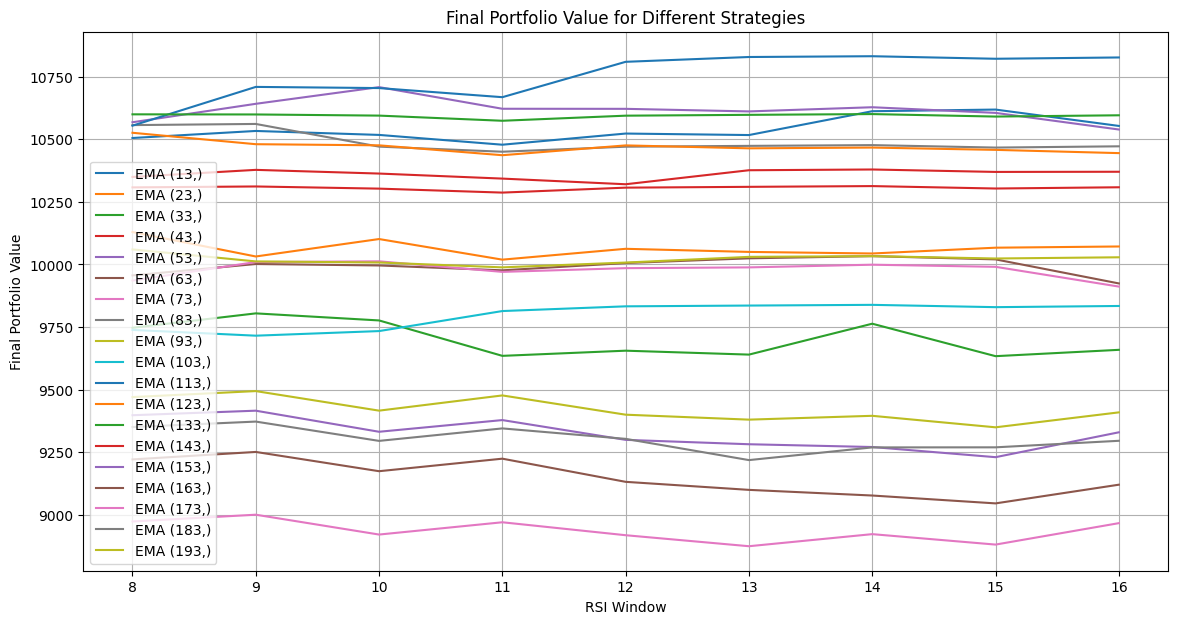

In [18]:
# Plot the results
plt.figure(figsize=(14, 7))
for key, grp in results_df.groupby(['EMA']):
    plt.plot(grp['RSI'], grp['Final_Portfolio_Value'], label=f'EMA {key}')

plt.xlabel('RSI Window')
plt.ylabel('Final Portfolio Value')
plt.title('Final Portfolio Value for Different Strategies')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Display the top strategies
top_strategies = results_df.sort_values(by='Final_Portfolio_Value', ascending=False).head(10)
print(top_strategies)

    EMA  RSI  MACD_Short  MACD_Long  MACD_Signal  Final_Portfolio_Value
96  113   14          13         34            8           10831.105212
95  113   13          13         34            8           10827.983181
98  113   16          13         34            8           10826.162828
97  113   15          13         34            8           10820.965188
94  113   12          13         34            8           10808.784073
91  113    9          13         34            8           10708.613383
38   53   10          13         34            8           10707.745461
92  113   10          13         34            8           10703.984633
93  113   11          13         34            8           10667.592380
37   53    9          13         34            8           10641.147170
